In [1]:
import os
import pandas as pd
import string
from datetime import datetime
from os import path
import json
import numpy as np
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open(path.expanduser("~") + "/sys_specific.json") as file: 
    params = json.load(file)
_HOME_ = params["home"] + "/PHD"

In [3]:
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [4]:
df_chem_phys = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data.csv")

In [5]:
df_chem_phys["id"] = pd.Categorical(df_chem_phys["id"], categories=ordered_id, ordered=True)
df_chem_phys["Region"] = pd.Categorical(df_chem_phys["Region"], categories=ordered_regions, ordered=True)
df_chem_phys["Date"] = pd.to_datetime(df_chem_phys["Date"])
df_chem_phys["SampleDepth"] = df_chem_phys["SampleDepth"].astype("float")

In [6]:
depth_threshold = 2

In [30]:
simplified_chem_phys = df_chem_phys.query("SampleDepth <= @depth_threshold")

In [31]:
simplified_chem_phys = simplified_chem_phys.loc[~simplified_chem_phys["QF"].isin(["3", "4"]), :]

In [8]:
nutrients = df_chem_phys["Nutrient"].unique()

In [34]:
simplified_chem_phys.loc[:, "SampleDepth"] = simplified_chem_phys.loc[:, "SampleDepth"].apply(lambda x: round(x * 2) / 2)

AttributeError: 'dict' object has no attribute 'query'

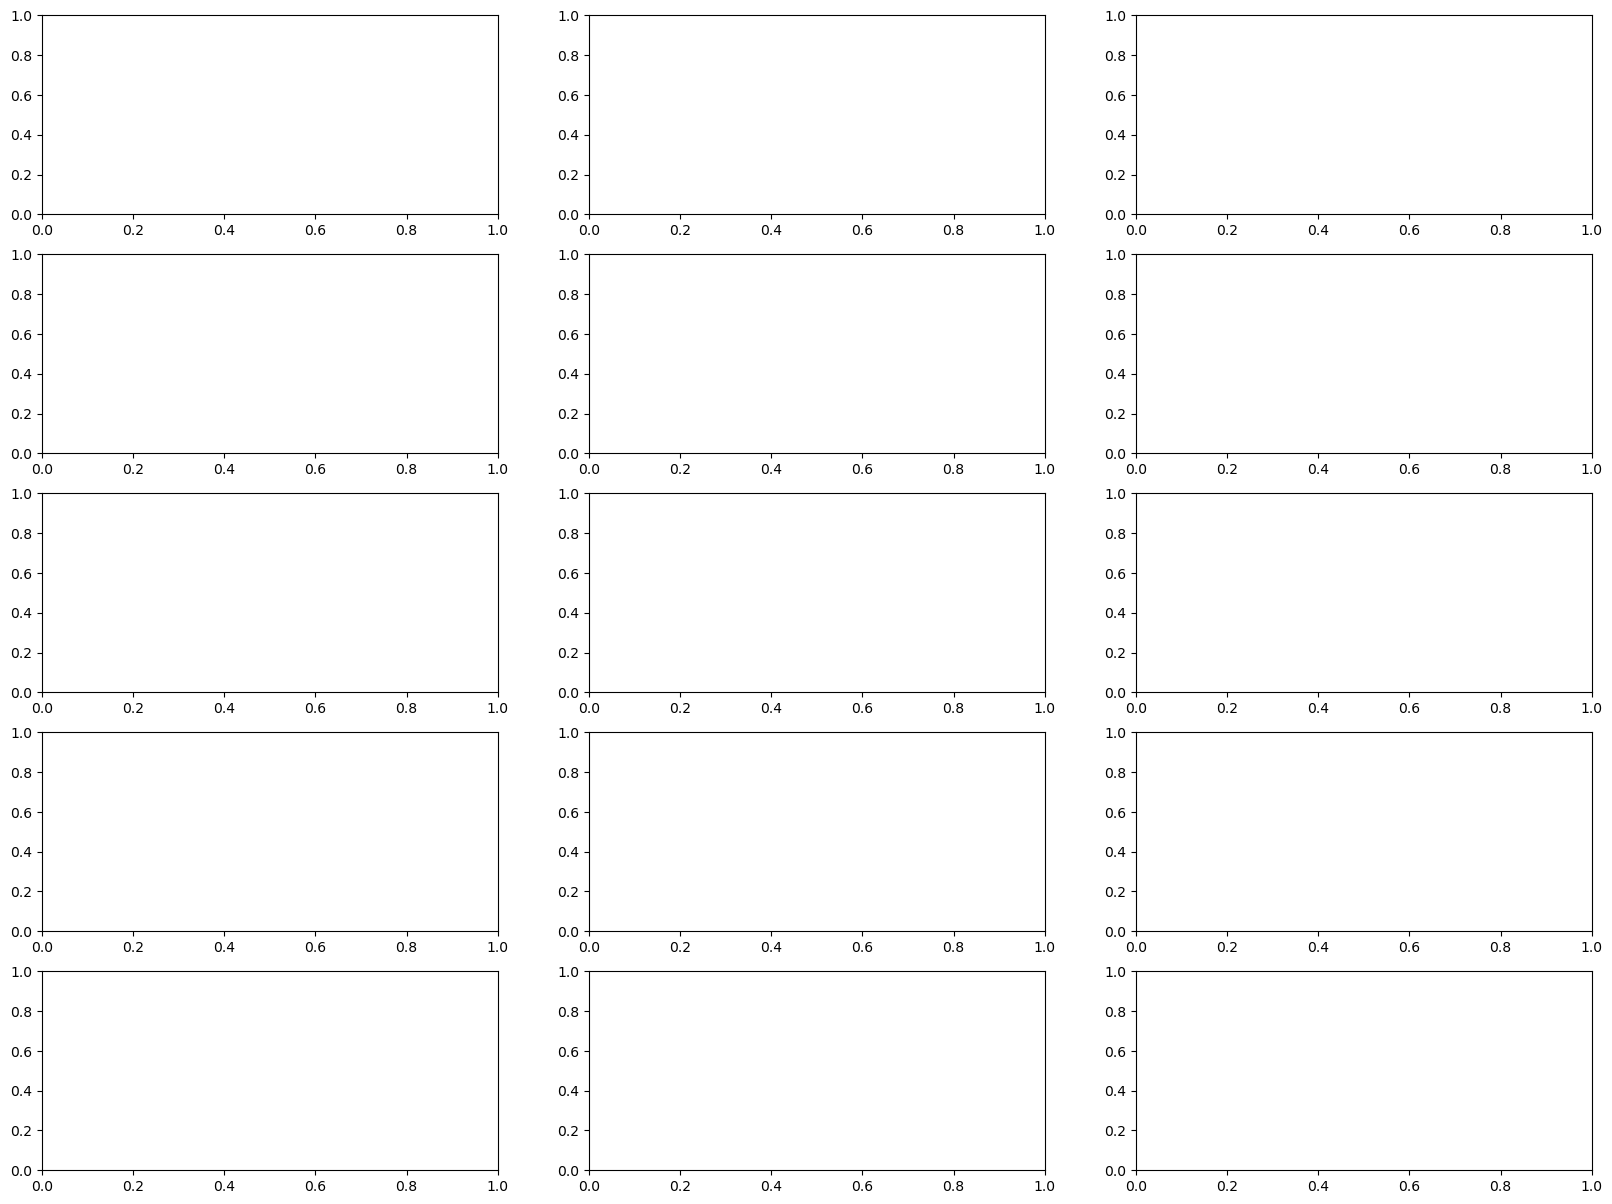

In [80]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15))
axs = axs.ravel()
for (nut, ax) in zip(nutrients, axs):
    df_nut = simplified_chem_phys.query("Nutrient == @nut")
    sns.histplot(data=df_nut, x="Concentration", ax=ax, bins=50)
    ax.set_title(nut)
plt.tight_layout()

In [56]:
df_temp = {}
for (nut, df_nut) in simplified_chem_phys.groupby("Nutrient"):
    df_temp[nut] = df_nut
simplified_chem_phys = df_temp

Chla
DO
E_cond
NH4
NO2
NO3
O_sat
PO4
Salinity
Secchi_depth
SiO4
T
TN
TP
pH


In [61]:
## remove wrong values
simplified_chem_phys["Salinity"] = simplified_chem_phys["Salinity"].query("Concentration > 15")

In [62]:
expression = "Concentration > 2.5"
simplified_chem_phys["T"] = simplified_chem_phys["T"].query(expression)

In [63]:
expression = "Concentration > 25 and Concentration < 200"
nut = "O_sat"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [84]:
expression = "Concentration <= 10 and Concentration >= 4"
nut = "pH"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [72]:
expression = "Concentration <= 20 and Concentration >0"
nut = "Chla"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [73]:
expression = "Concentration <= 100"
nut = "NO3"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [77]:
expression = "Concentration <= 3"
nut = "PO4"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [75]:
expression = "Concentration <= 20"
nut = "NH4"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [76]:
expression = "Concentration <= 5"
nut = "TP"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [78]:
expression = "Concentration <= 150"
nut = "TN"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [79]:
expression = "Concentration <= 60"
nut = "SiO4"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [94]:
expression = "Concentration >= 100"
nut = "DO"
simplified_chem_phys[nut]["Concentration"] = simplified_chem_phys[nut]["Concentration"].apply(lambda x: x * 0.0821 * 298.15 if x < 100 else x)
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

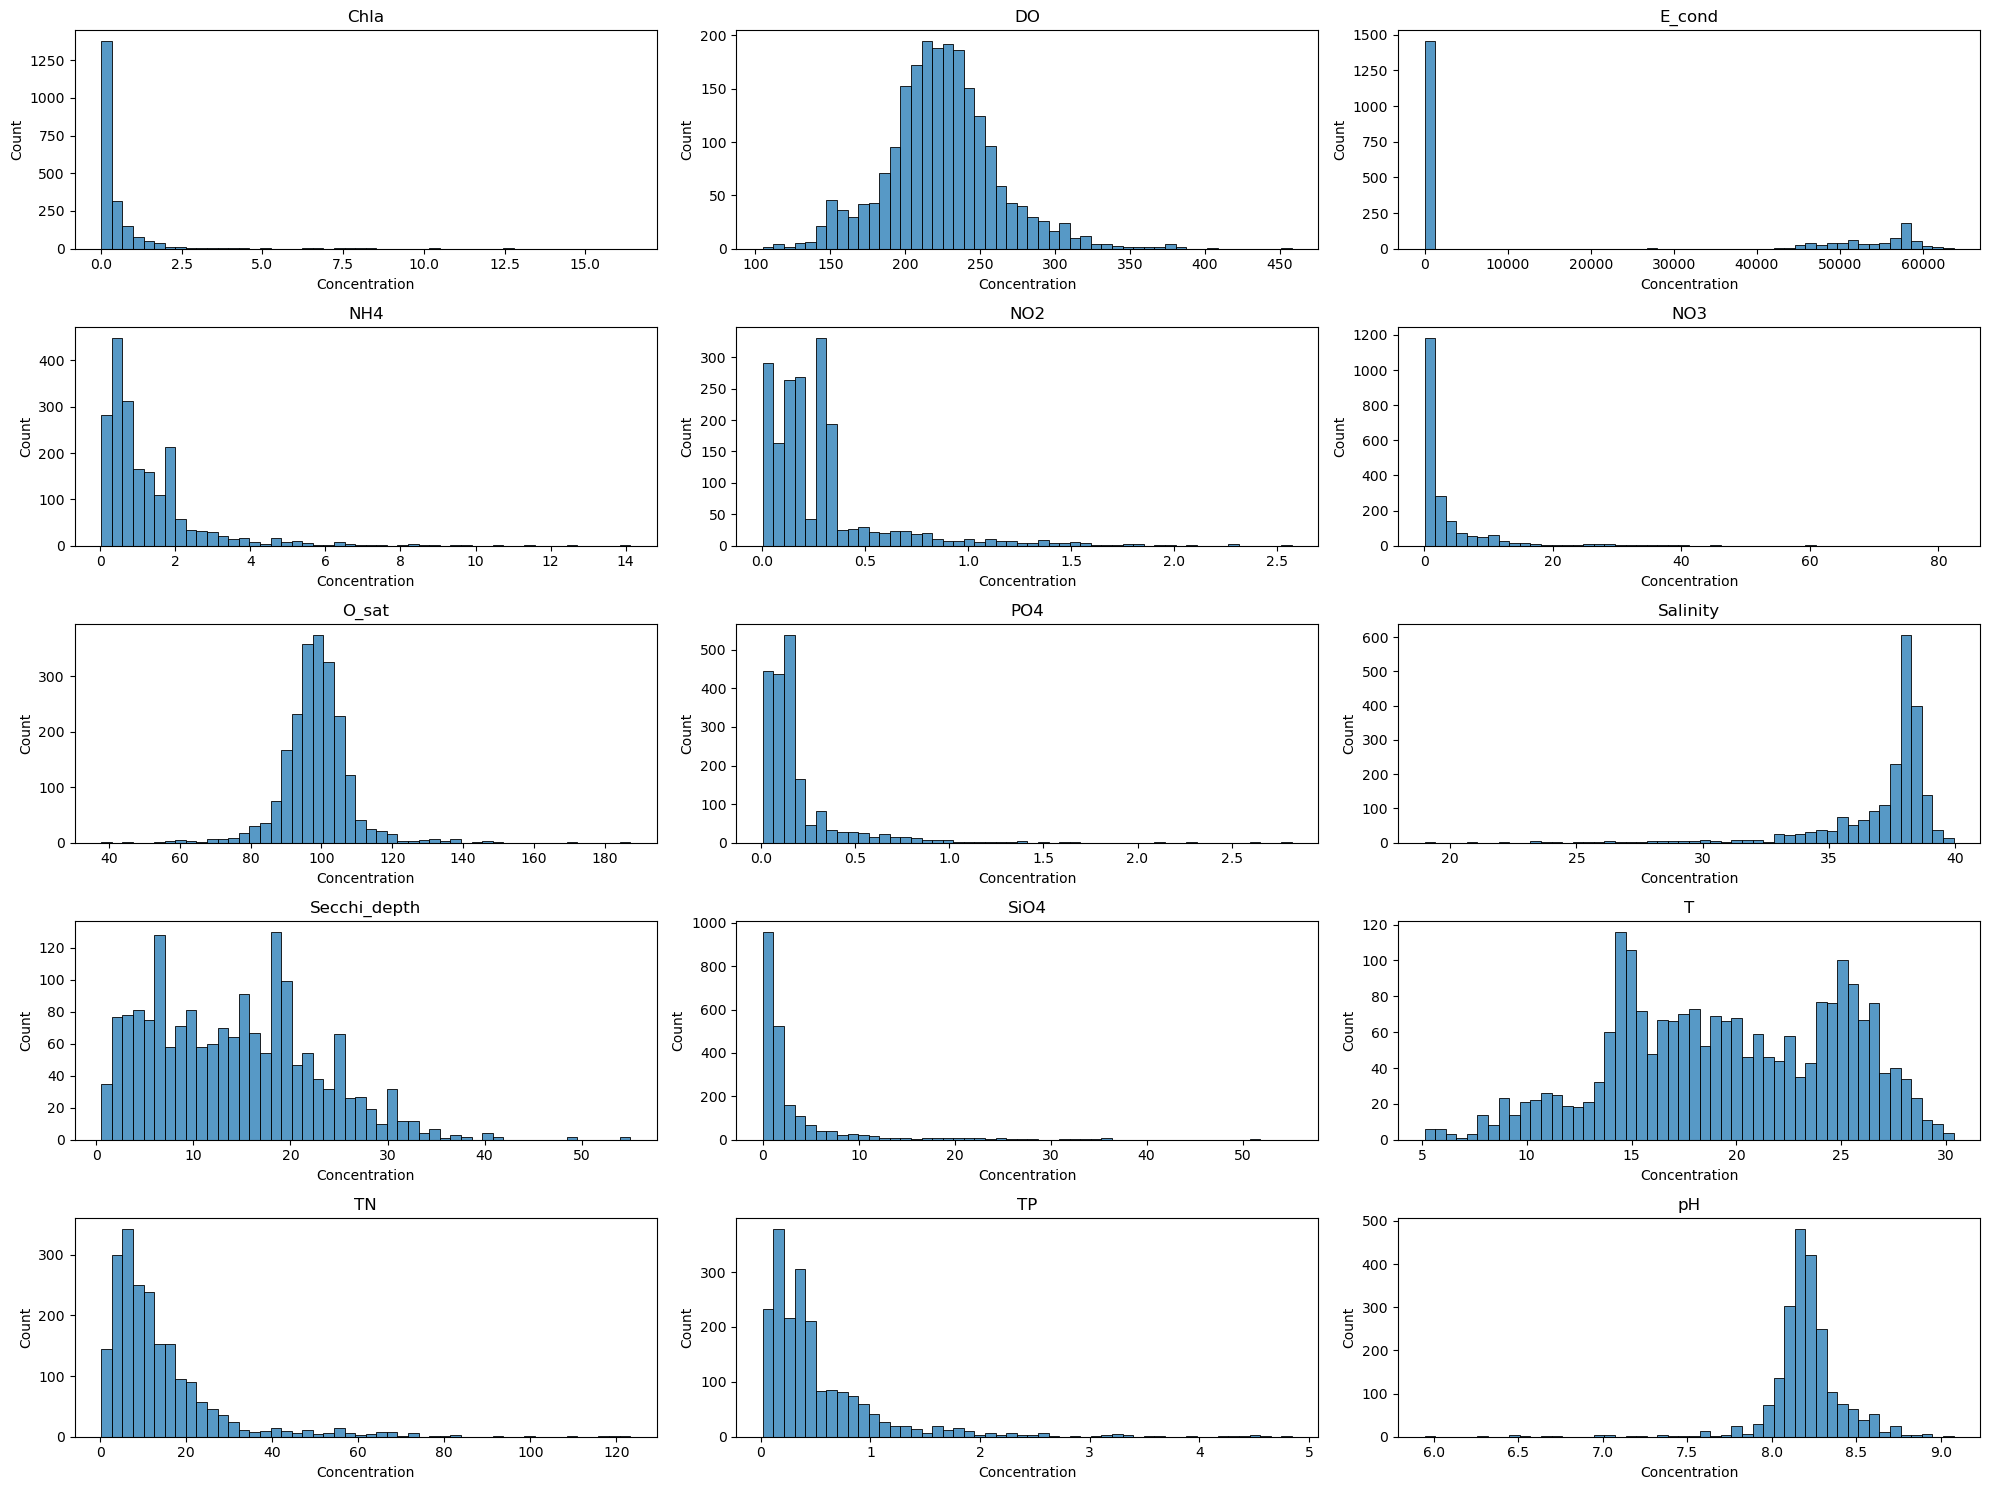

In [99]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15))
axs = axs.ravel()
for ((nut, df_nut), ax) in zip(simplified_chem_phys.items(), axs):
    sns.histplot(data=df_nut.groupby(["id", "Date"], observed = True).mean(numeric_only = True), x="Concentration", ax=ax, bins=50)
    ax.set_title(nut)
plt.tight_layout()

In [ ]:
"<" quantiticabilità
"]" rilevabilità

In [96]:
N = len(simplified_chem_phys.keys())
min = np.zeros(N)
max = np.zeros(N)
nut_index = np.empty(N, dtype = "<U10")
for k, (nut, df_nut) in enumerate(simplified_chem_phys.items()):
    nut_index[k] = nut
    Q1 = df_nut["Concentration"].quantile(0.25)
    Q3 = df_nut["Concentration"].quantile(0.75)
    IQR = Q3 - Q1
    min[k] = Q1 - 1.5 * IQR
    max[k] = Q3 + 1.5 * IQR
outliers_df = pd.DataFrame(
    data = {
        "min" : min, 
        "max" : max
    }, 
    index = nut_index
)
outliers_df[outliers_df <= 0] = 0
outliers_df

,min,max
Chla,0.000000,1.175000
DO,139.519775,308.300375
E_cond,0.000000,122355.192525
NH4,0.000000,3.737500
NO2,0.000000,0.727500
NO3,0.000000,8.920000
O_sat,80.150000,116.550000
PO4,0.000000,0.380000
Salinity,34.377700,40.570500
Secchi_dep,0.000000,39.500000


In [38]:
for nut in nutrients: 
    print(nut)
    display(simplified_chem_phys.query("Nutrient == @nut")["Concentration"].describe())

Salinity


count    6123.000000
mean       37.022965
std         2.481911
min         0.000000
25%        36.700000
50%        37.945400
75%        38.248050
max        39.950000
Name: Concentration, dtype: float64

T


count    6358.000000
mean       19.452669
std         5.442805
min         0.000000
25%        15.113300
50%        19.294850
75%        24.450850
max        31.902500
Name: Concentration, dtype: float64

E_cond


count     6351.000000
mean     16790.022161
std      24987.698907
min          0.000000
25%         46.121650
50%         54.423400
75%      48969.750000
max      65341.355000
Name: Concentration, dtype: float64

DO


count    6294.000000
mean      210.709745
std        72.097876
min         0.000000
25%       201.562500
50%       223.125000
75%       244.687500
max       466.854284
Name: Concentration, dtype: float64

O_sat


count    6308.000000
mean       98.308261
std        11.631275
min         0.000000
25%        93.800000
50%        98.310000
75%       102.900000
max       248.125000
Name: Concentration, dtype: float64

pH


count    6335.000000
mean        8.296421
std         3.067664
min         0.000000
25%         8.120000
50%         8.199000
75%         8.287000
max       101.900000
Name: Concentration, dtype: float64

Chla


count    6197.000000
mean        0.670615
std         2.051730
min        -1.430000
25%         0.100000
50%         0.200000
75%         0.540000
max        52.427000
Name: Concentration, dtype: float64

Secchi_depth


count    1787.000000
mean       14.206212
std         8.513761
min         0.500000
25%         7.000000
50%        14.000000
75%        20.000000
max        55.000000
Name: Concentration, dtype: float64

NO3


count    2034.000000
mean        4.335768
std        11.866604
min         0.020000
25%         0.320000
50%         1.000000
75%         3.785286
max       251.142900
Name: Concentration, dtype: float64

NO2


count    1910.000000
mean        0.350001
std         0.887546
min         0.003000
25%         0.110000
50%         0.200000
75%         0.357000
max        14.000000
Name: Concentration, dtype: float64

NH4


count    2008.000000
mean        1.306599
std         1.966050
min         0.030000
25%         0.450000
50%         0.789500
75%         1.770000
max        63.285700
Name: Concentration, dtype: float64

TP


count    2019.000000
mean        0.607395
std         1.078704
min         0.020000
25%         0.180000
50%         0.400000
75%         0.660000
max        20.100000
Name: Concentration, dtype: float64

PO4


count    1978.000000
mean        0.199910
std         0.290204
min         0.010000
25%         0.080000
50%         0.160000
75%         0.200000
max         4.875700
Name: Concentration, dtype: float64

TN


count    2111.000000
mean       14.436588
std        16.742359
min         0.200000
25%         5.600000
50%        10.071400
75%        17.121450
max       252.714290
Name: Concentration, dtype: float64

SiO4


count    2144.000000
mean        3.619091
std         8.274493
min         0.001000
25%         0.707500
50%         1.250000
75%         3.000000
max       142.450100
Name: Concentration, dtype: float64